In [1]:
# imports from custom library (this won't be shown in the HTML version)
import sys
sys.path.append('../../')
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
from mlrefined_libraries import convnets_library as convlib
from mlrefined_libraries import basics_library as baslib
import autograd.numpy as np
import pandas as pd
import cv2

#this is needed to compensate for matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

## 2D convolution: review

Press the button 'Toggle code' below to toggle code on and off for entire this presentation.

In [14]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

\begin{equation}
y_{n_1,\,n_2} = \underset{\ell_1=-L_1}{\overset{L_1}{\sum}}\underset{\ell_2=-L_2}{\overset{L_2}{\sum}}{w_{\ell_1,\,\ell_2}\,x_{n_1+\ell_1,\,n_2+\ell_2}}
\end{equation}

- $w$ is the convolution kernel/filter, of size $\left(2L_1+1\right) \times \left(2L_2+1\right)$
- $x$ is the input image originally of size $ N_1 \times N_2$, padded with zeros to become $\left(N_1+2L_1\right) \times \left(N_2+2L_2\right)$
- $y$ is the convolution image, of size $ N_1 \times N_2$  

### Computing convolution graphically


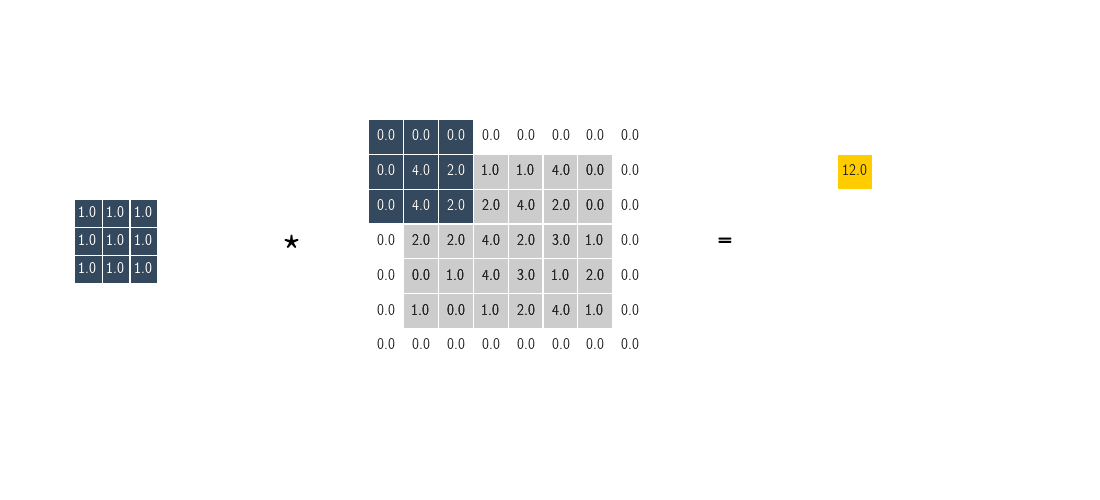
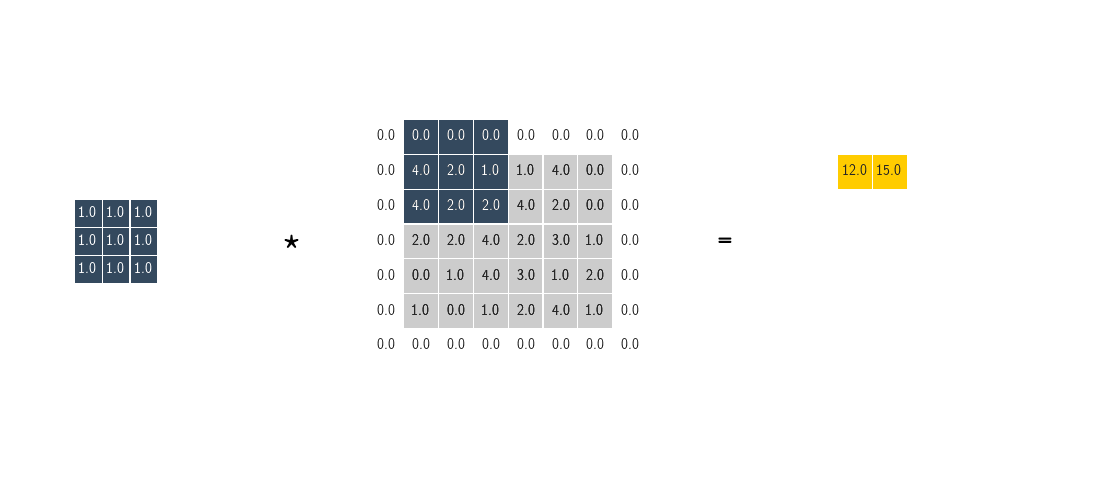
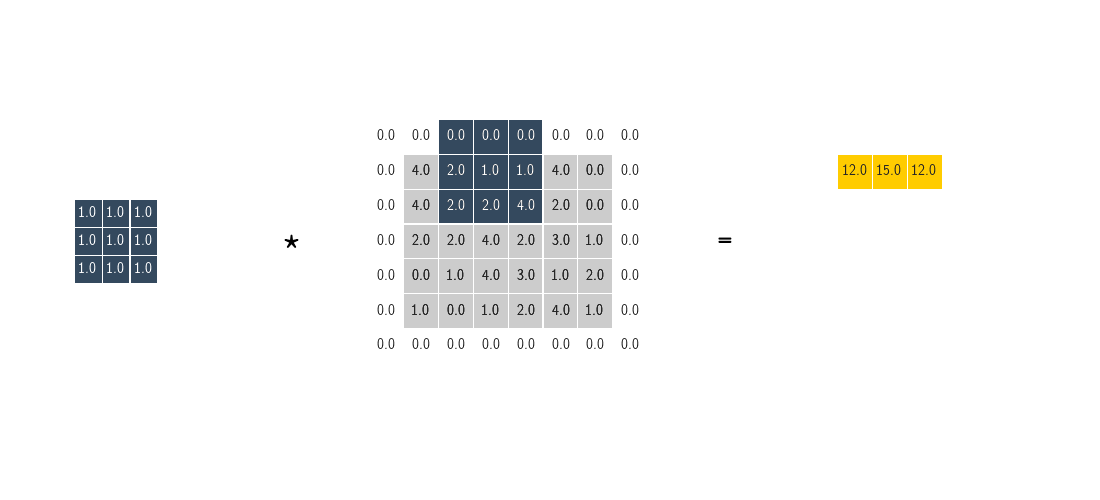
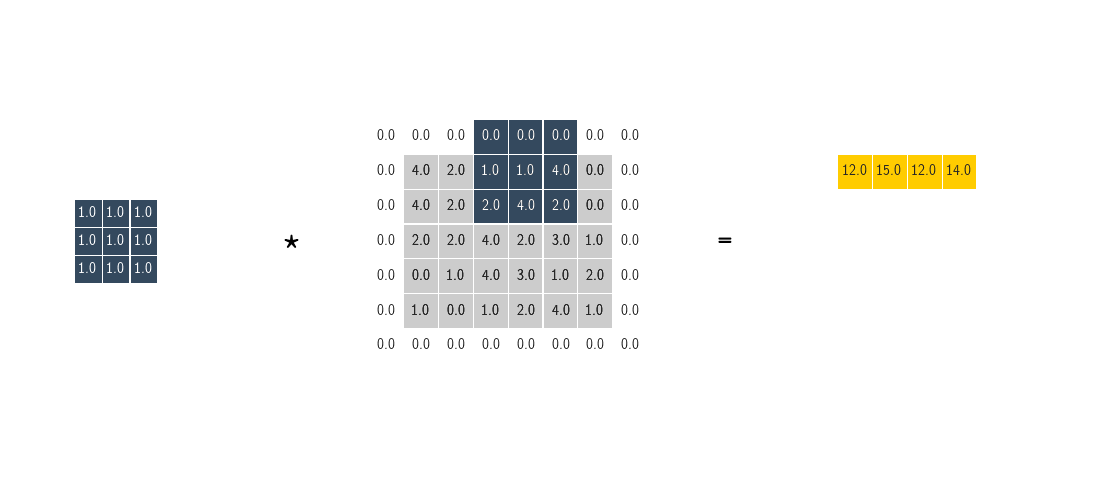
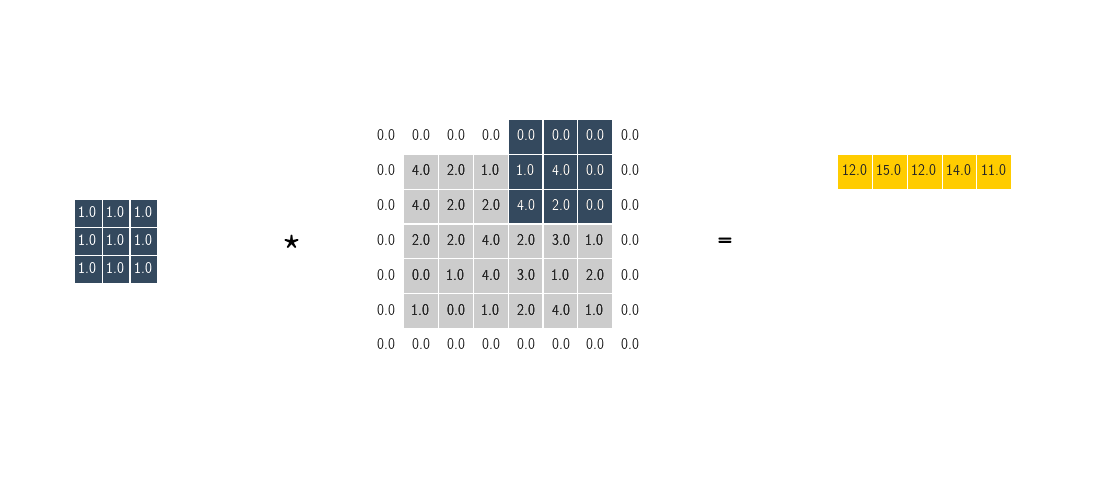
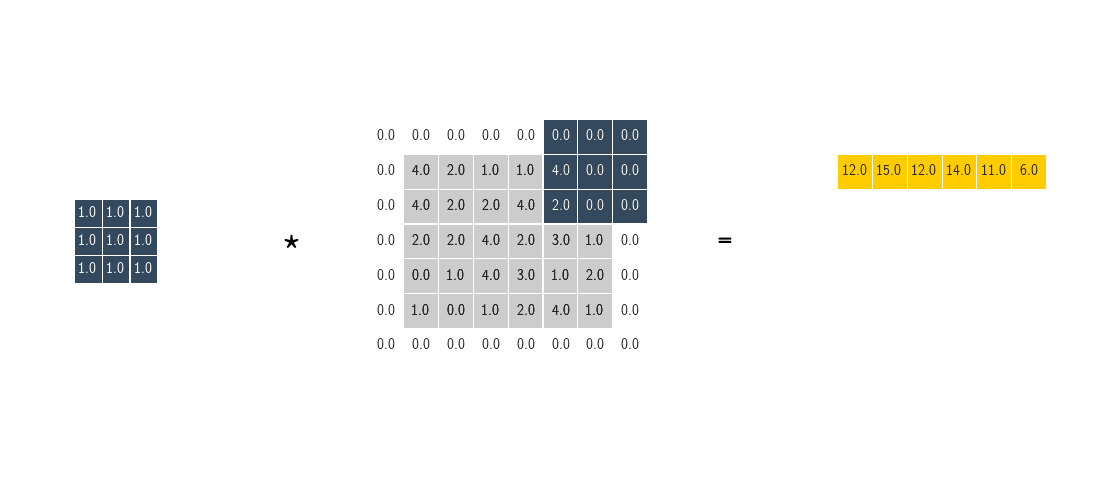
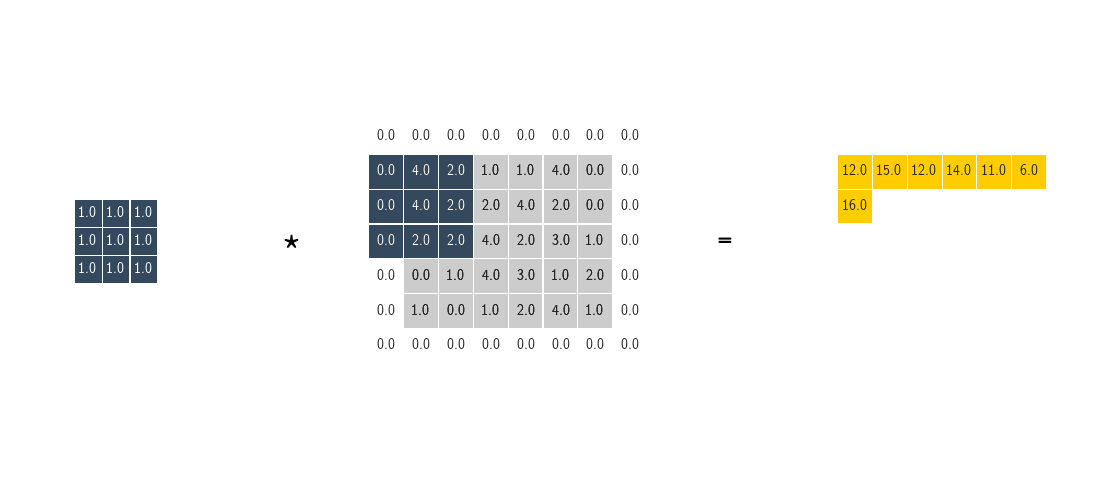
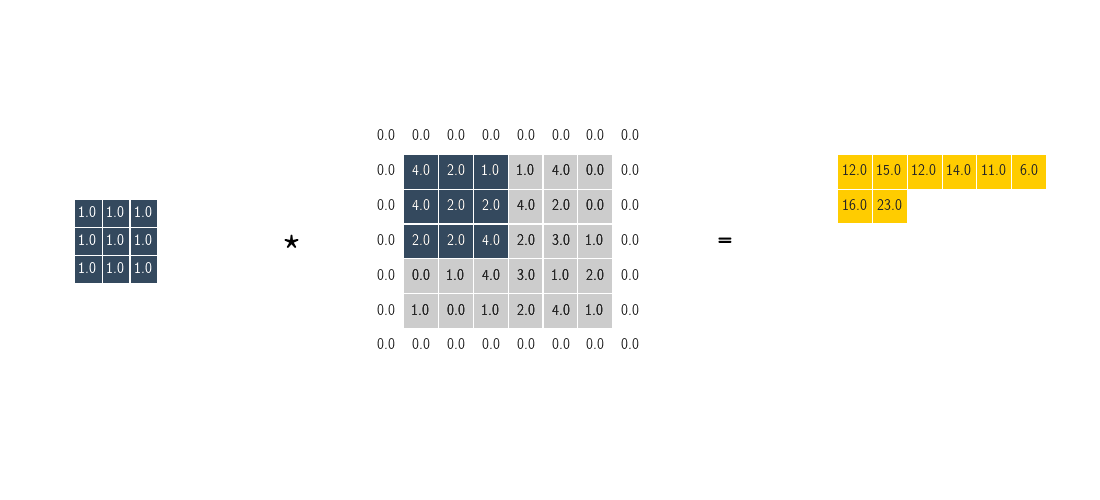
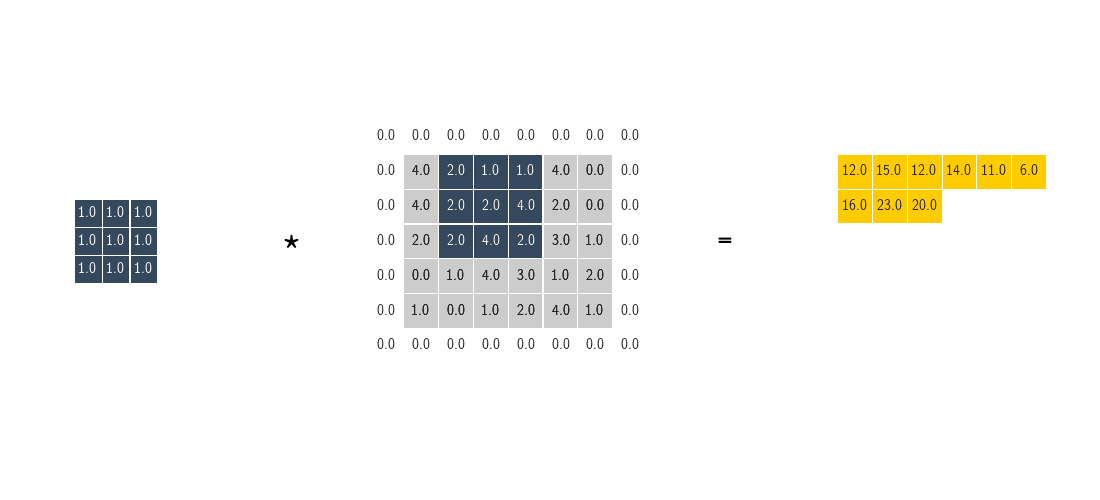
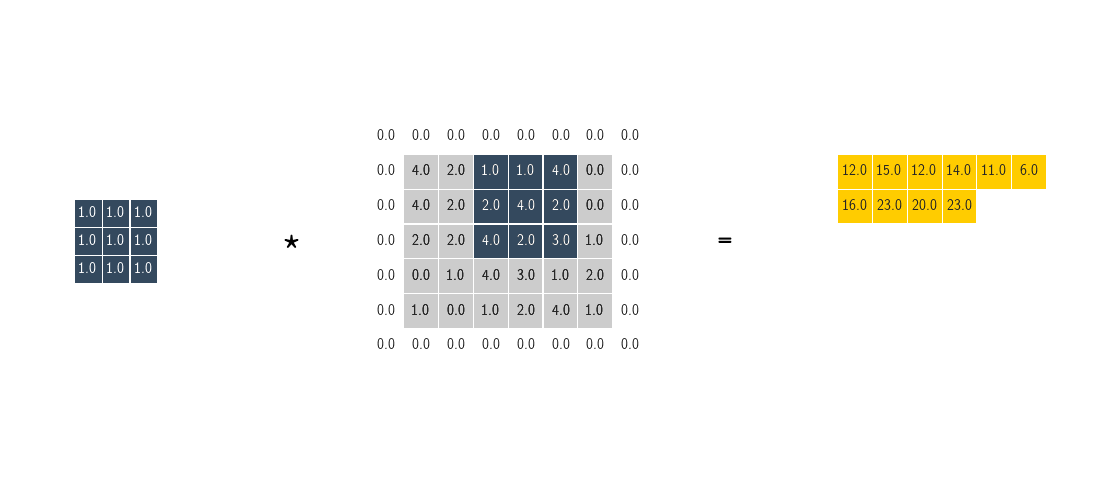
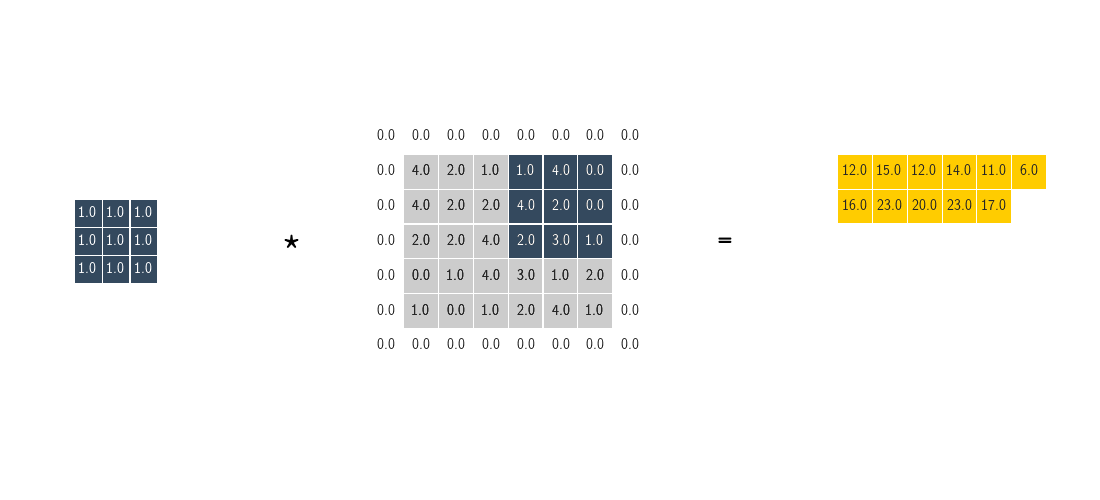
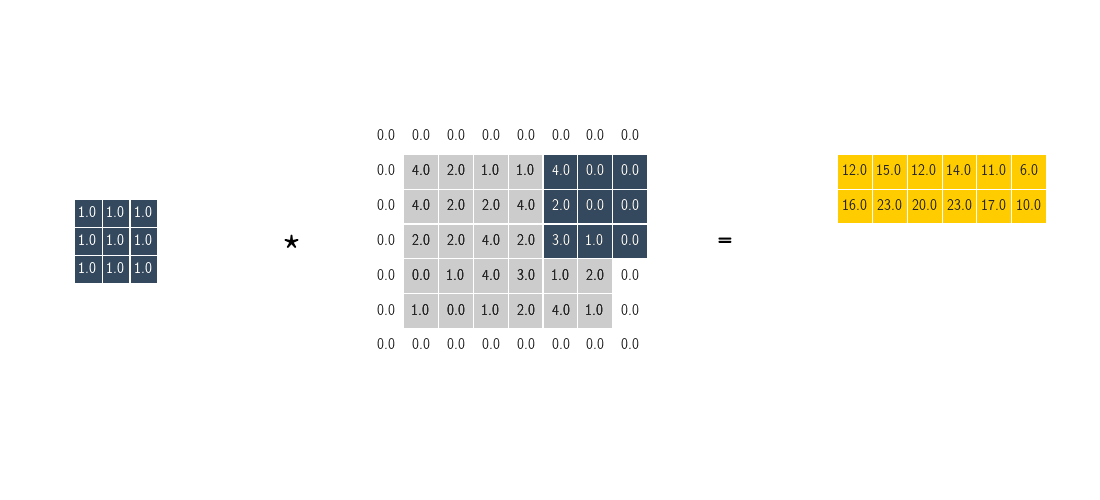
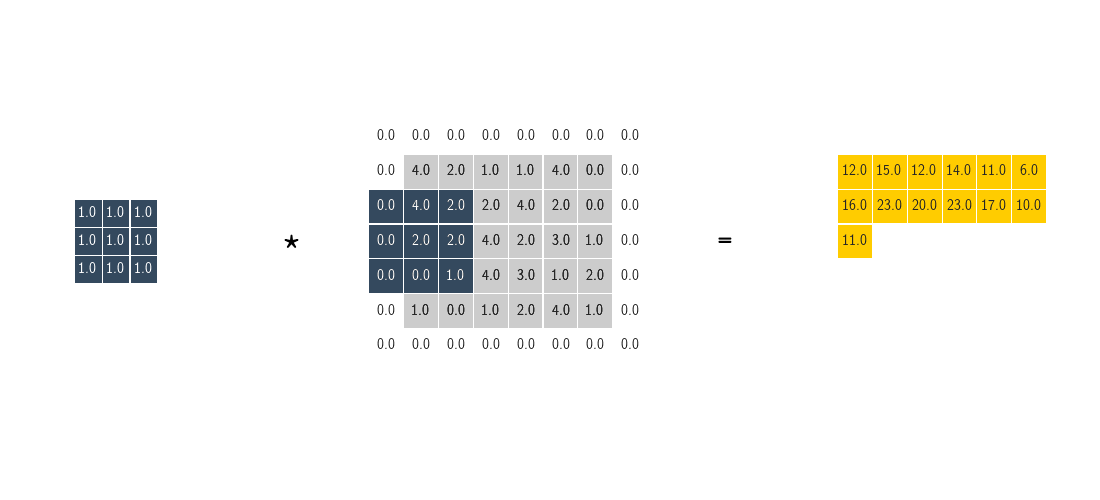
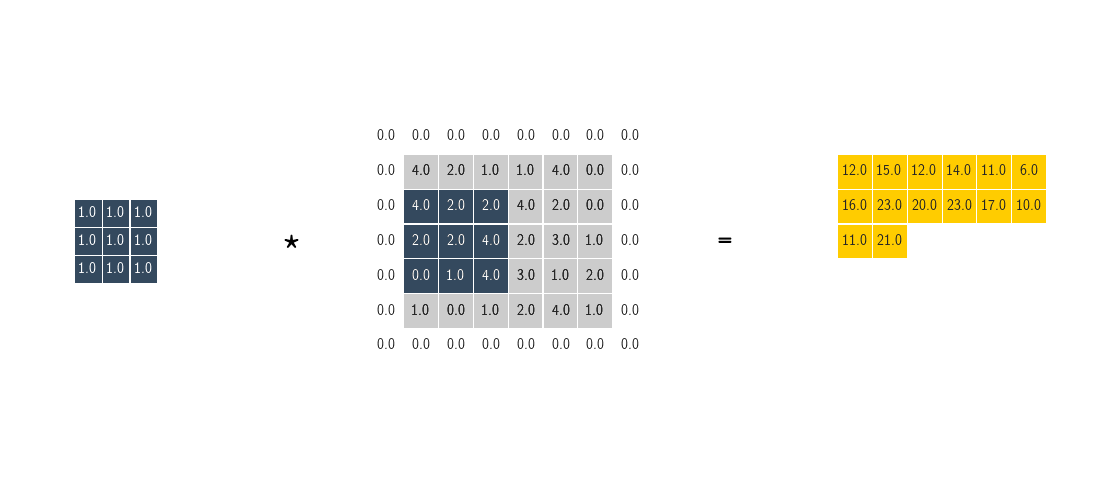
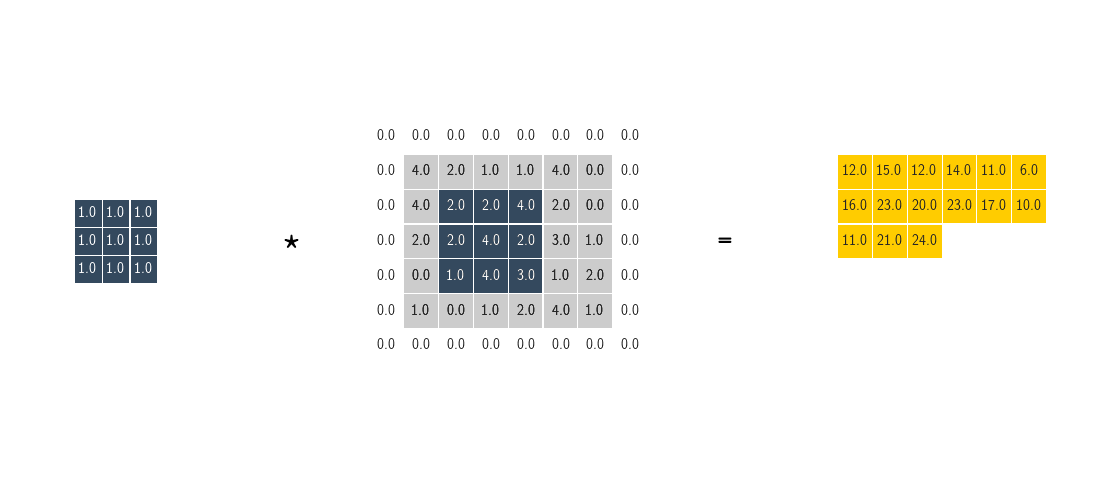
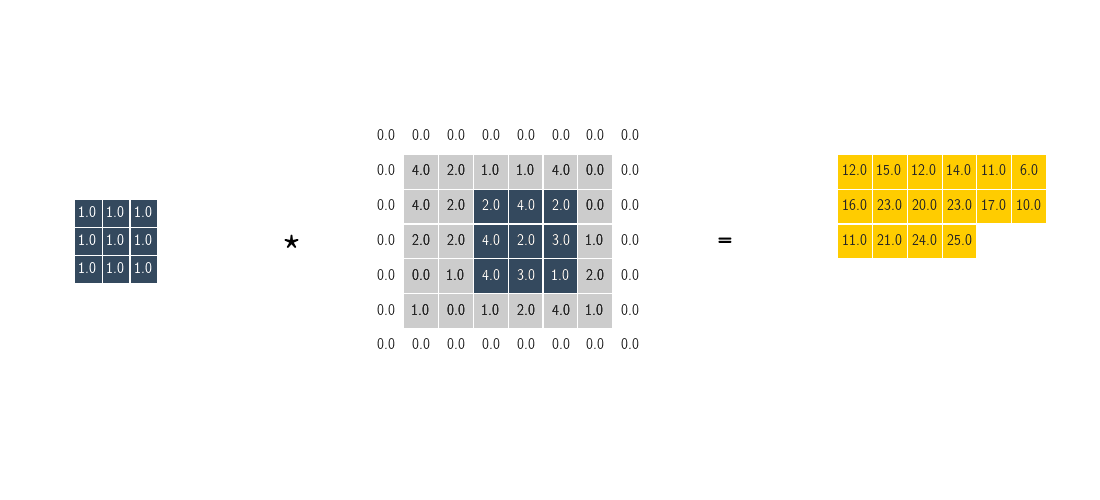
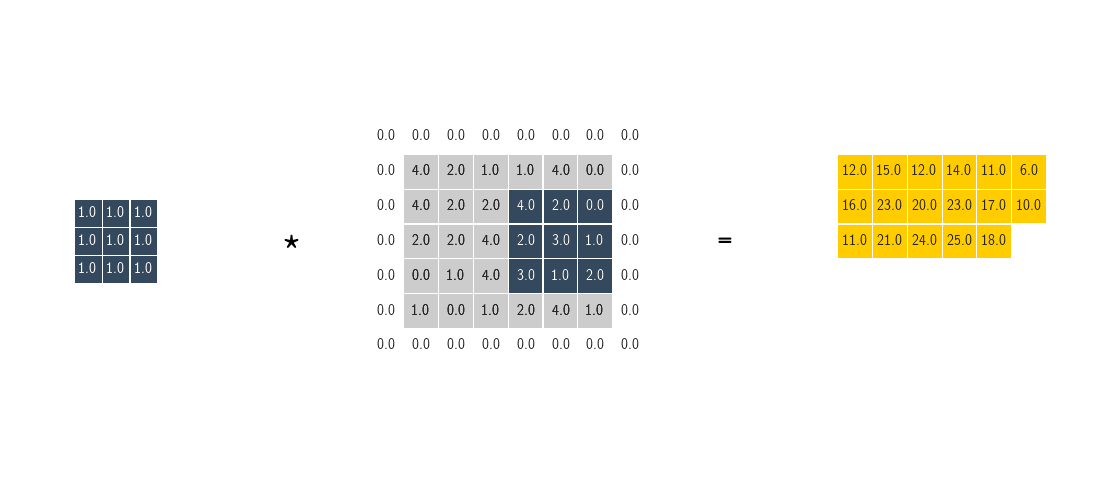
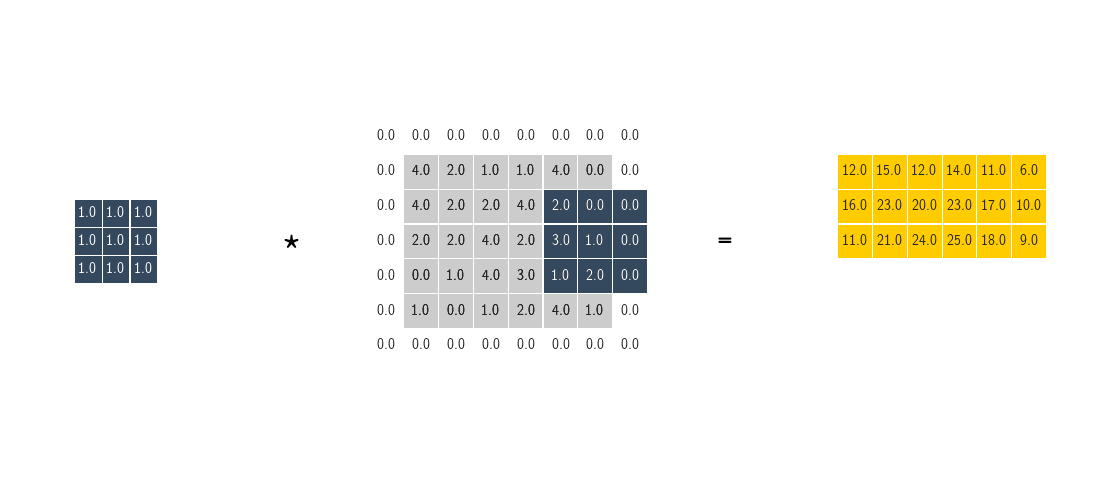
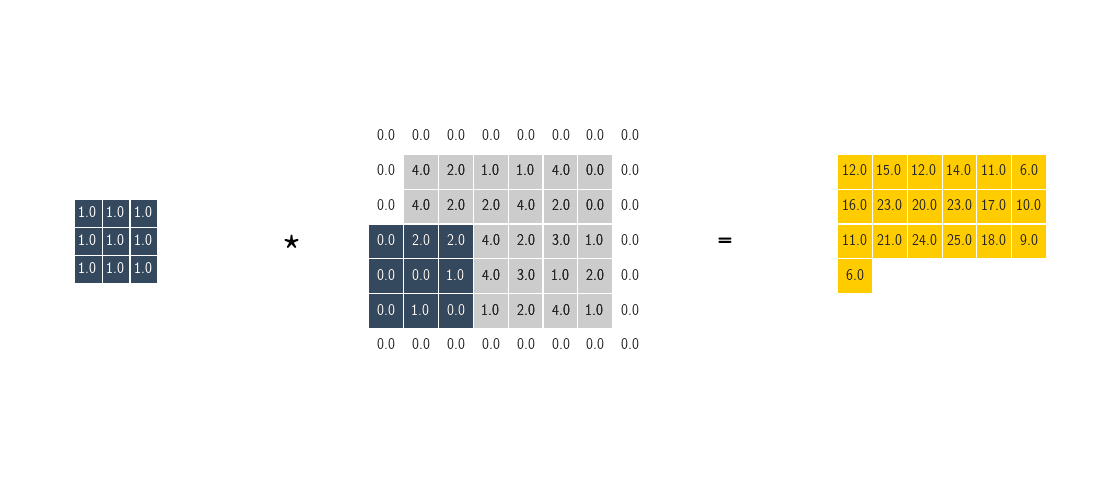
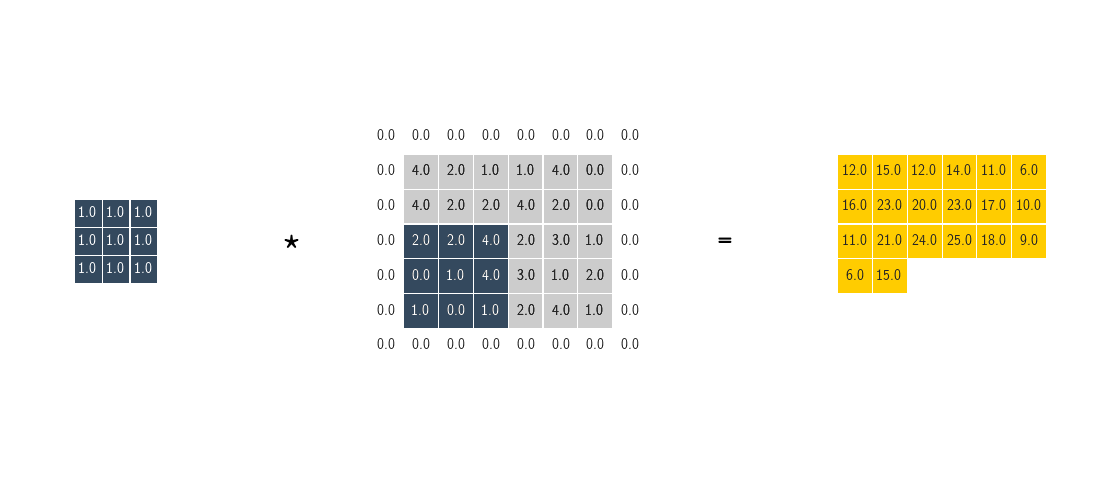
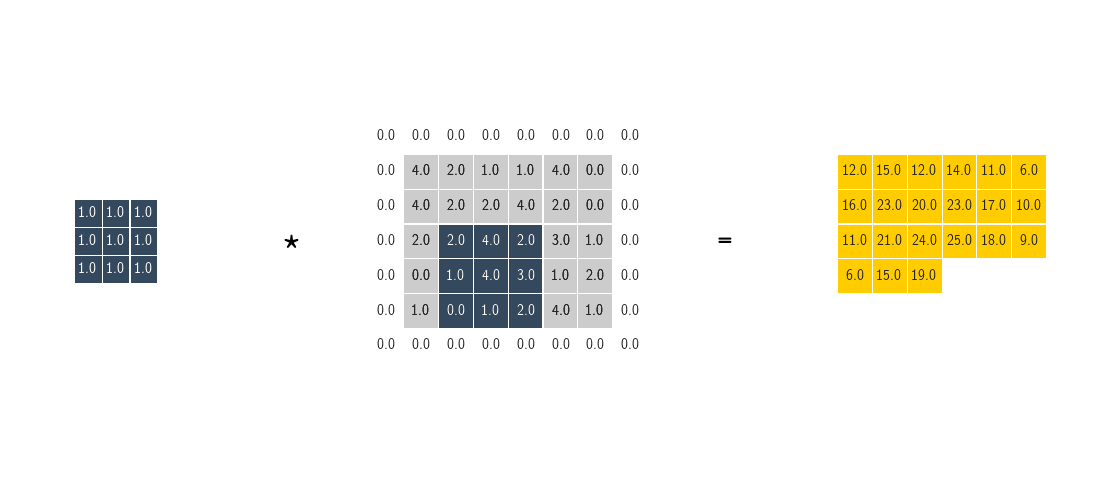
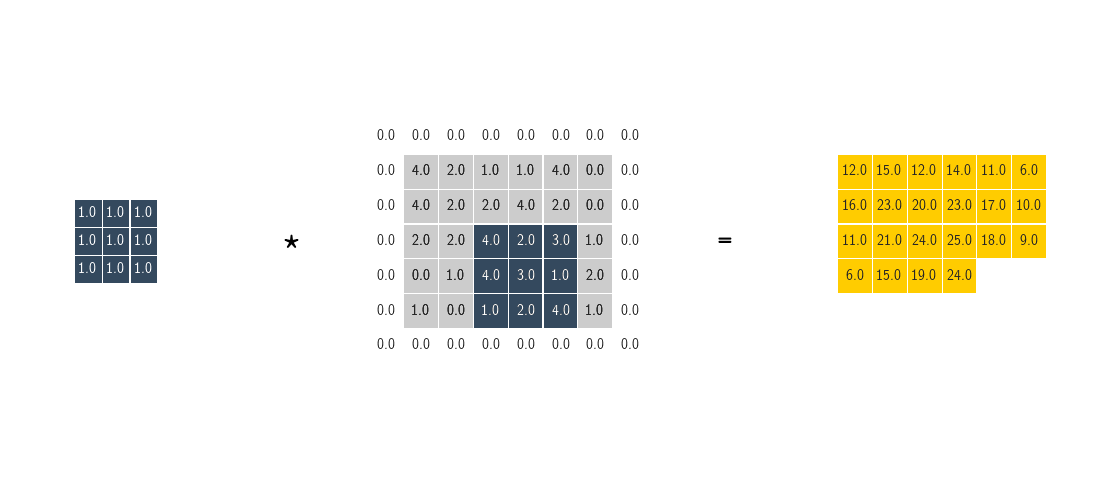
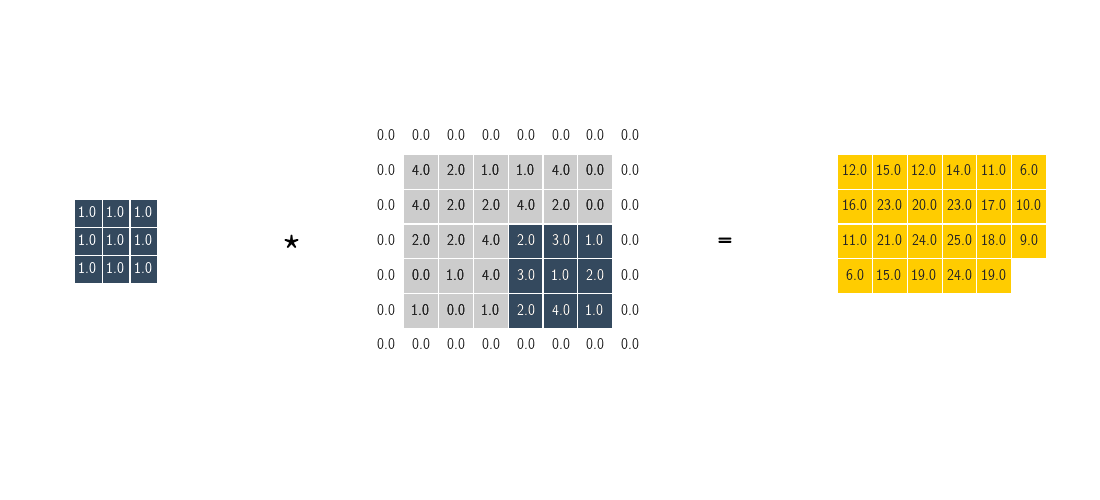
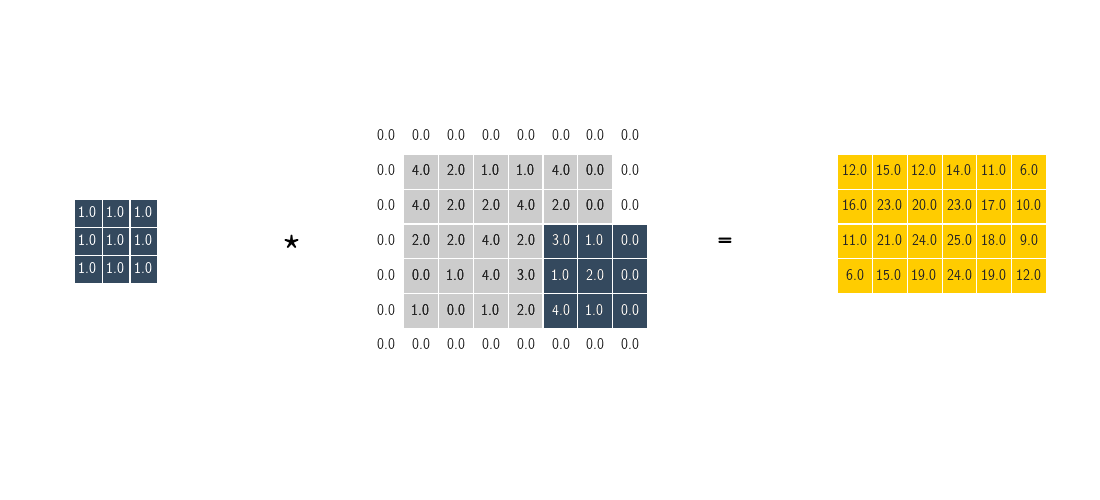
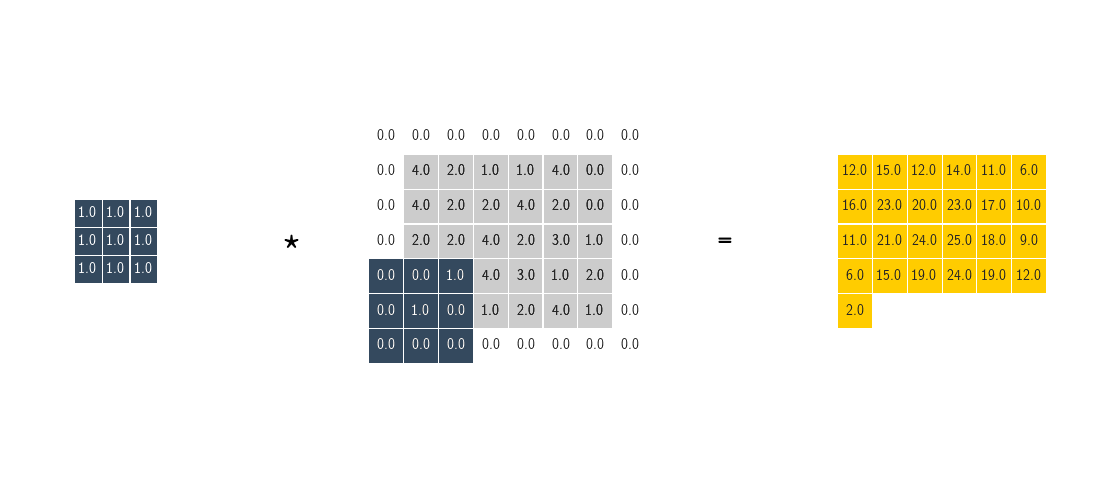
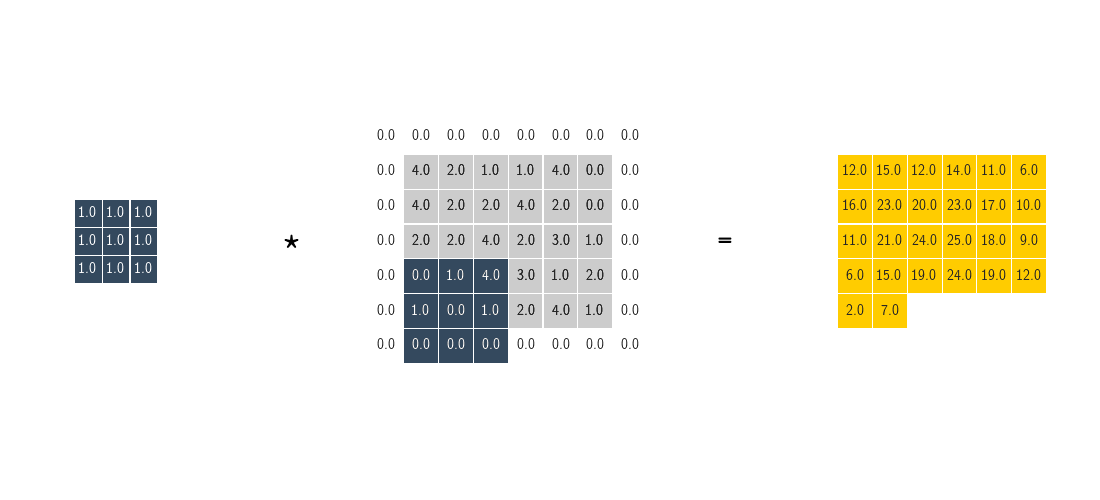
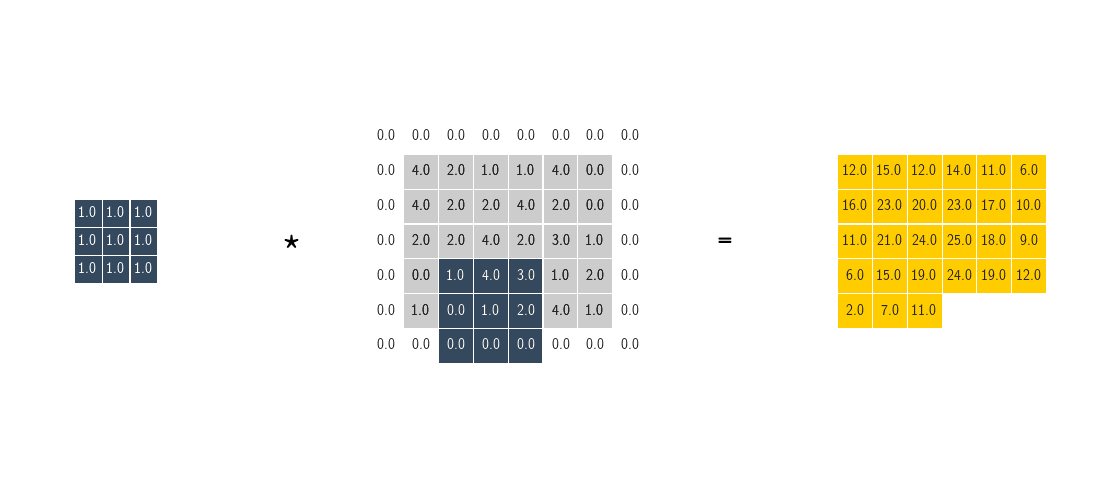
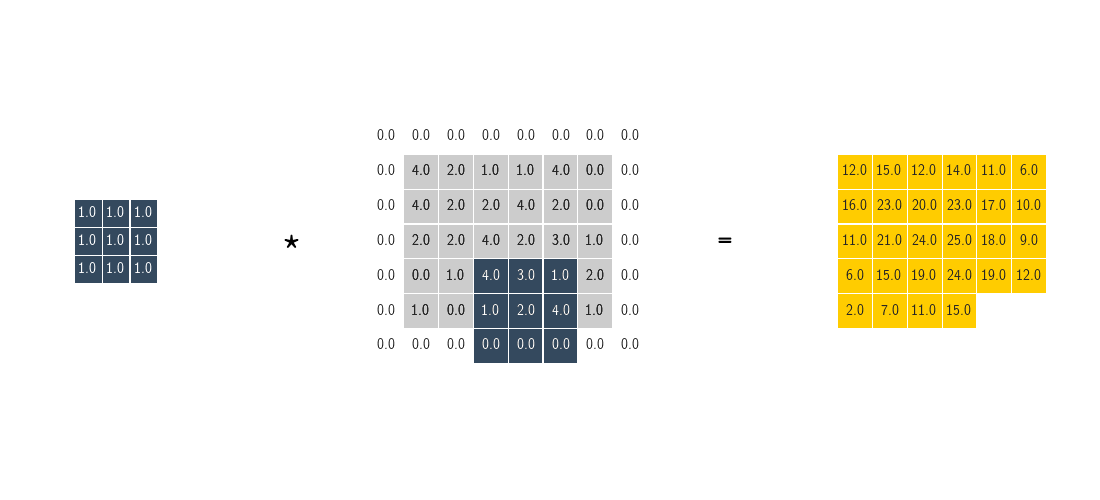
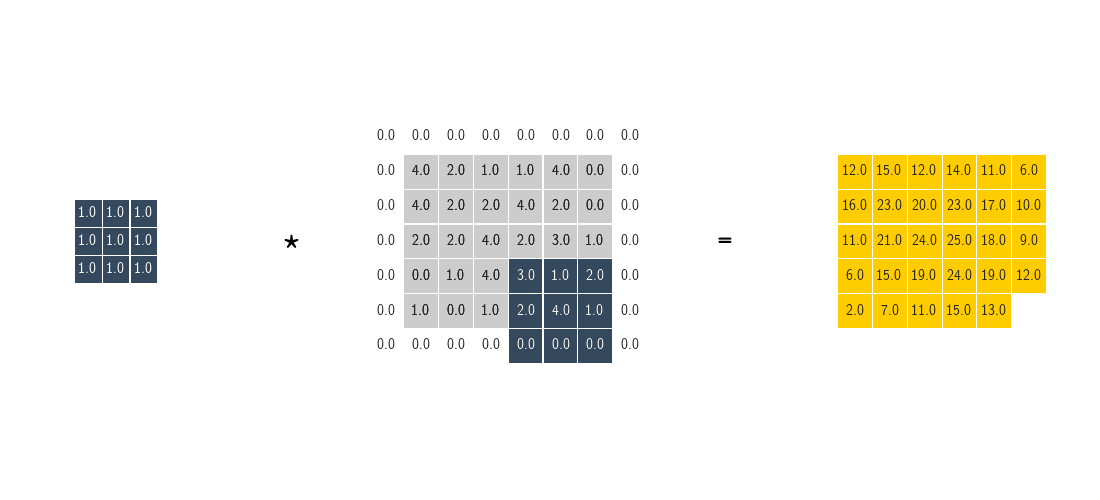
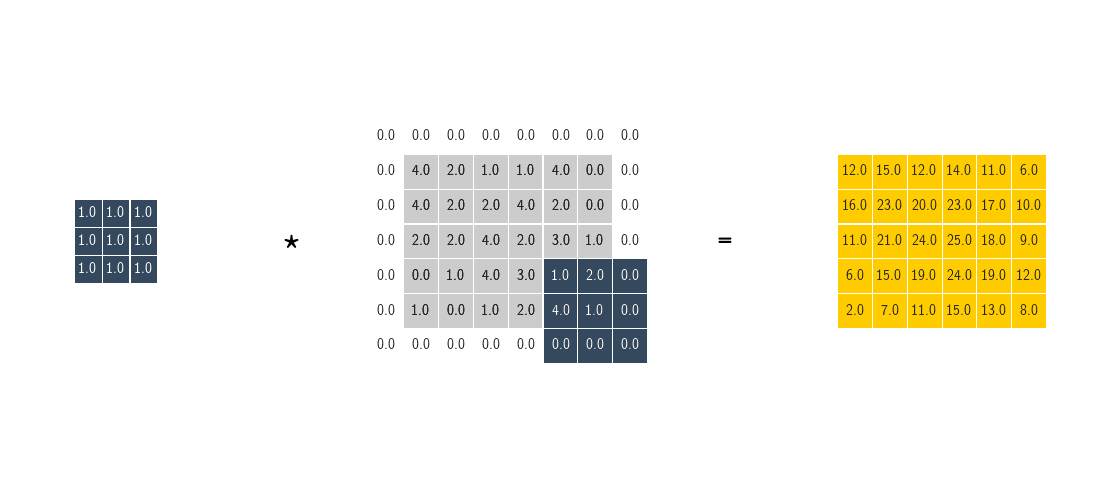

In [17]:
image = np.random.randint(5, size=(5,6))
kernel = np.ones((3,3))

# create an instance of the visualizer with this input sequence
conv_viz = convlib.sliding_convolution.visualizer(image = image, kernel = kernel)

# run the visualizer for our chosen input sequence
conv_viz.draw_it()

### (naive) Python implementation

In [9]:
def myZeroPadding(image, kernel):
            
    # get kernel dimensions
    # we assume the kernel is (2L1+1) by (2L2+1)
    L1 = int((np.shape(kernel)[0]-1)/2)
    L2 = int((np.shape(kernel)[1]-1)/2)
    
    # add fully zero rows to the top and bottom of the image
    fully_zero_rows = np.zeros((L1, np.shape(image)[1]))
    image = np.concatenate((fully_zero_rows, image), 0)
    image = np.concatenate((image, fully_zero_rows), 0)
            
    # add fully zero columns to the left and right of the image     
    fully_zero_cols = np.zeros((np.shape(image)[0], L2))
    image = np.concatenate((fully_zero_cols, image), 1)
    image = np.concatenate((image, fully_zero_cols), 1)
   
    return image

In [13]:
def myConv(image, kernel):
            
    # pad the input image with zeros
    padded_image = myZeroPadding(image, kernel)
    
    # initialize the convolution image 
    conv = np.zeros(np.shape(image))
    
    # get kernel dimensions
    L1, L2 = np.shape(kernel)
    
    # compute convolution entry-wise by sliding the kernel over the image
    for i in range(0, np.shape(image)[0]):
        for j in range(0, np.shape(image)[1]):
            conv[i,j] = np.sum(kernel*padded_img[i:i+L1, j:j+L2])
            
    return conv

### Edge detection via convolution 

<IPython.core.display.Javascript object>


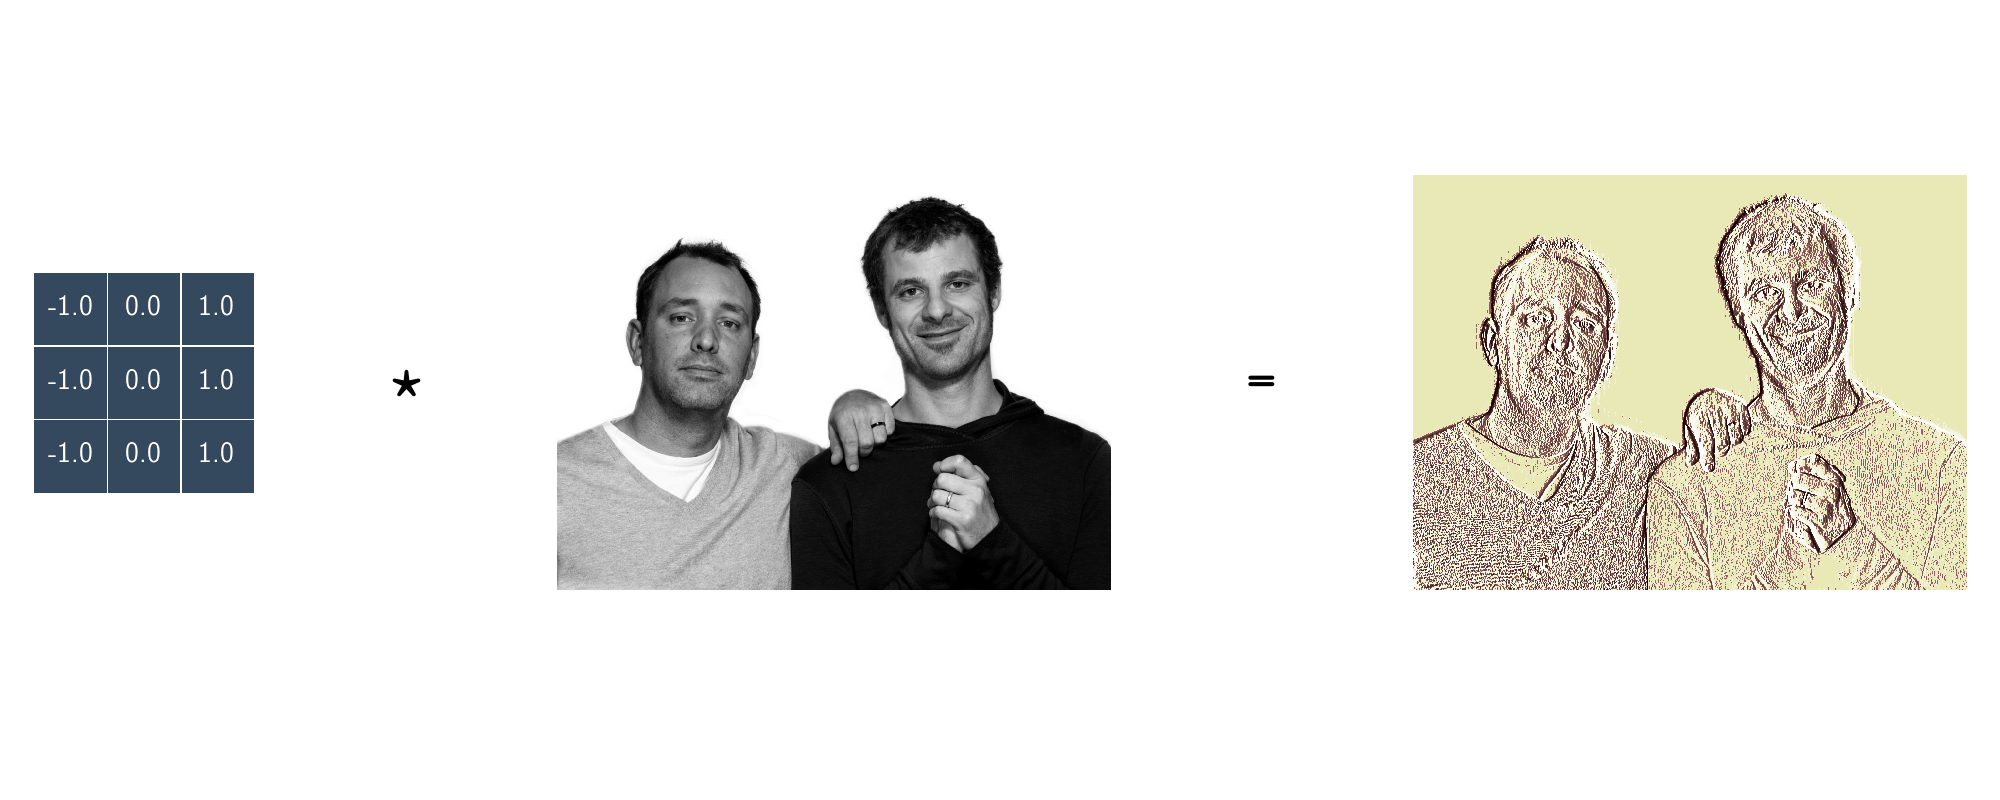

<IPython.core.display.Javascript object>


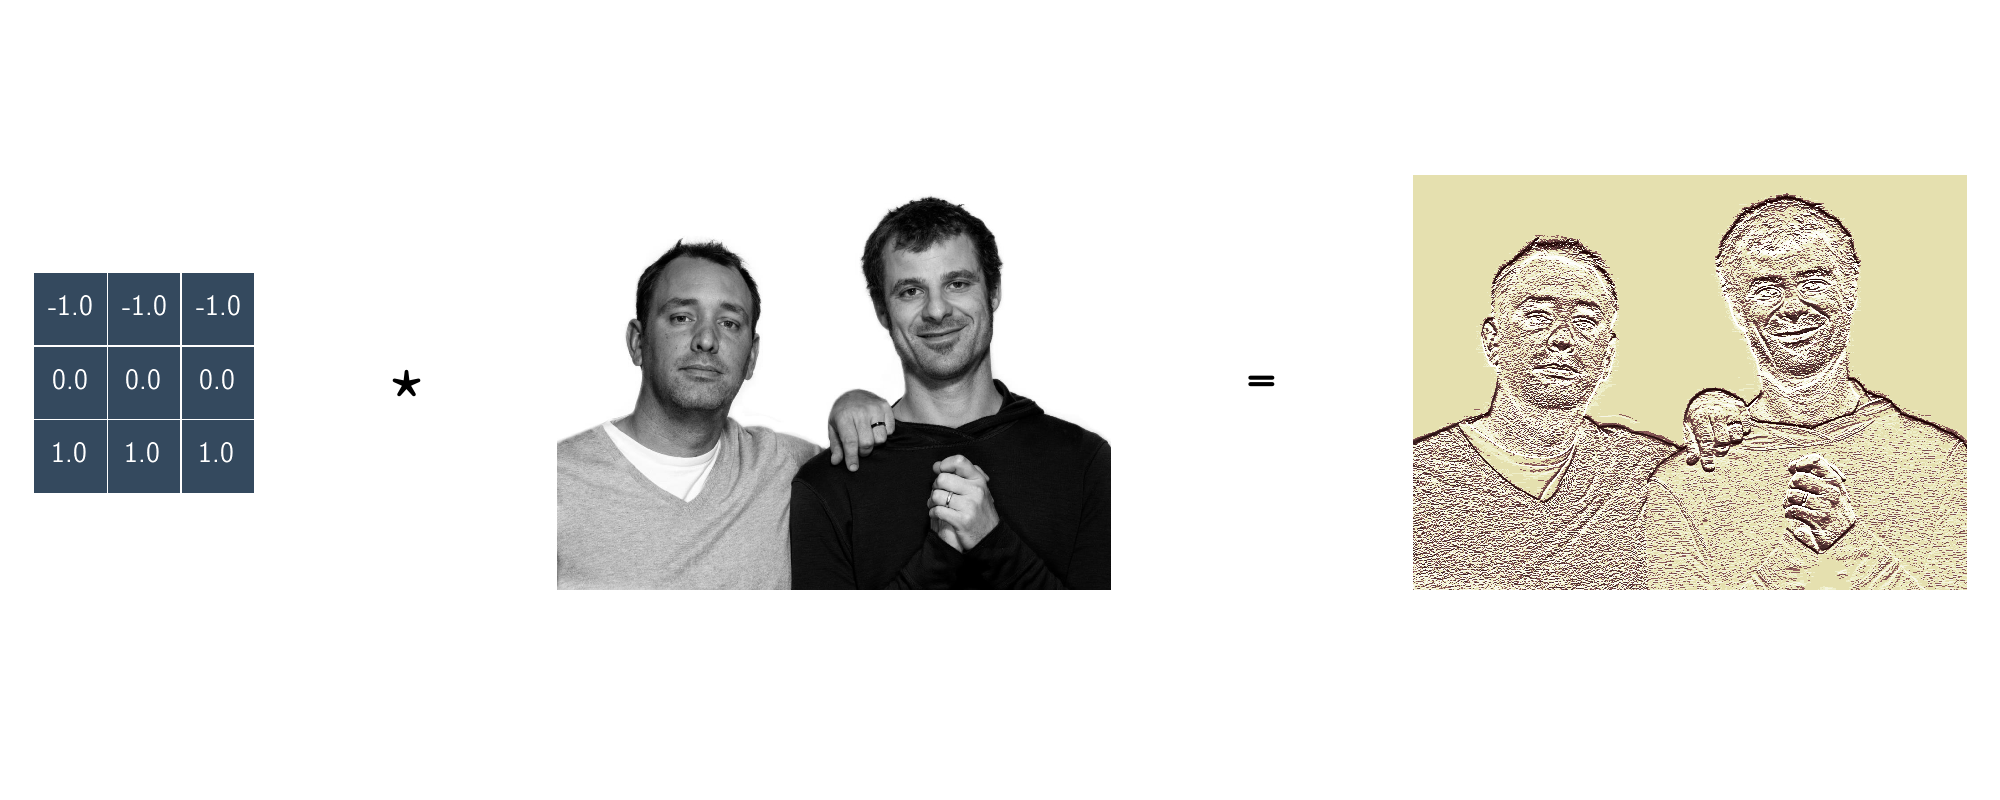

In [3]:
image_path = '../../mlrefined_images/convnet_images/dudes.png'



kernel_1 = np.array([[-1,  0,  1],
                     [-1,  0,  1],
                     [-1,  0,  1]])


kernel_2 = np.array([[-1, -1, -1],
                     [ 0,  0,  0],
                     [ 1,  1,  1]])



# compute and plot convolution images
convlib.kernel_viz.show_conv(image_path, kernel_1, contrast_normalization=True)
convlib.kernel_viz.show_conv(image_path, kernel_2, contrast_normalization=True)

### face detection data

In [4]:
 def load_data(csvname):
    # load in data
    data = np.asarray(pd.read_csv(csvname))

    # import data and reshape appropriately
    X = data[:,0:-1]
    y = data[:,-1]
    y.shape = (len(y),1)
    
    X_square = np.zeros((len(y),28,28))
    for i in range(0,len(y)):
        X_square[i,:,:] = np.reshape(X[i,:],(28,28),1)
    
    # pad data with ones for more compact gradient computation
    o = np.ones((np.shape(X)[0],1))
    X = np.concatenate((o,X),axis = 1)
    X = X.T
    
    return X,X_square,y

# load data
X,X_square, y = load_data('../../mlrefined_datasets/convnet_datasets/feat_face_data.csv')

<IPython.core.display.Javascript object>


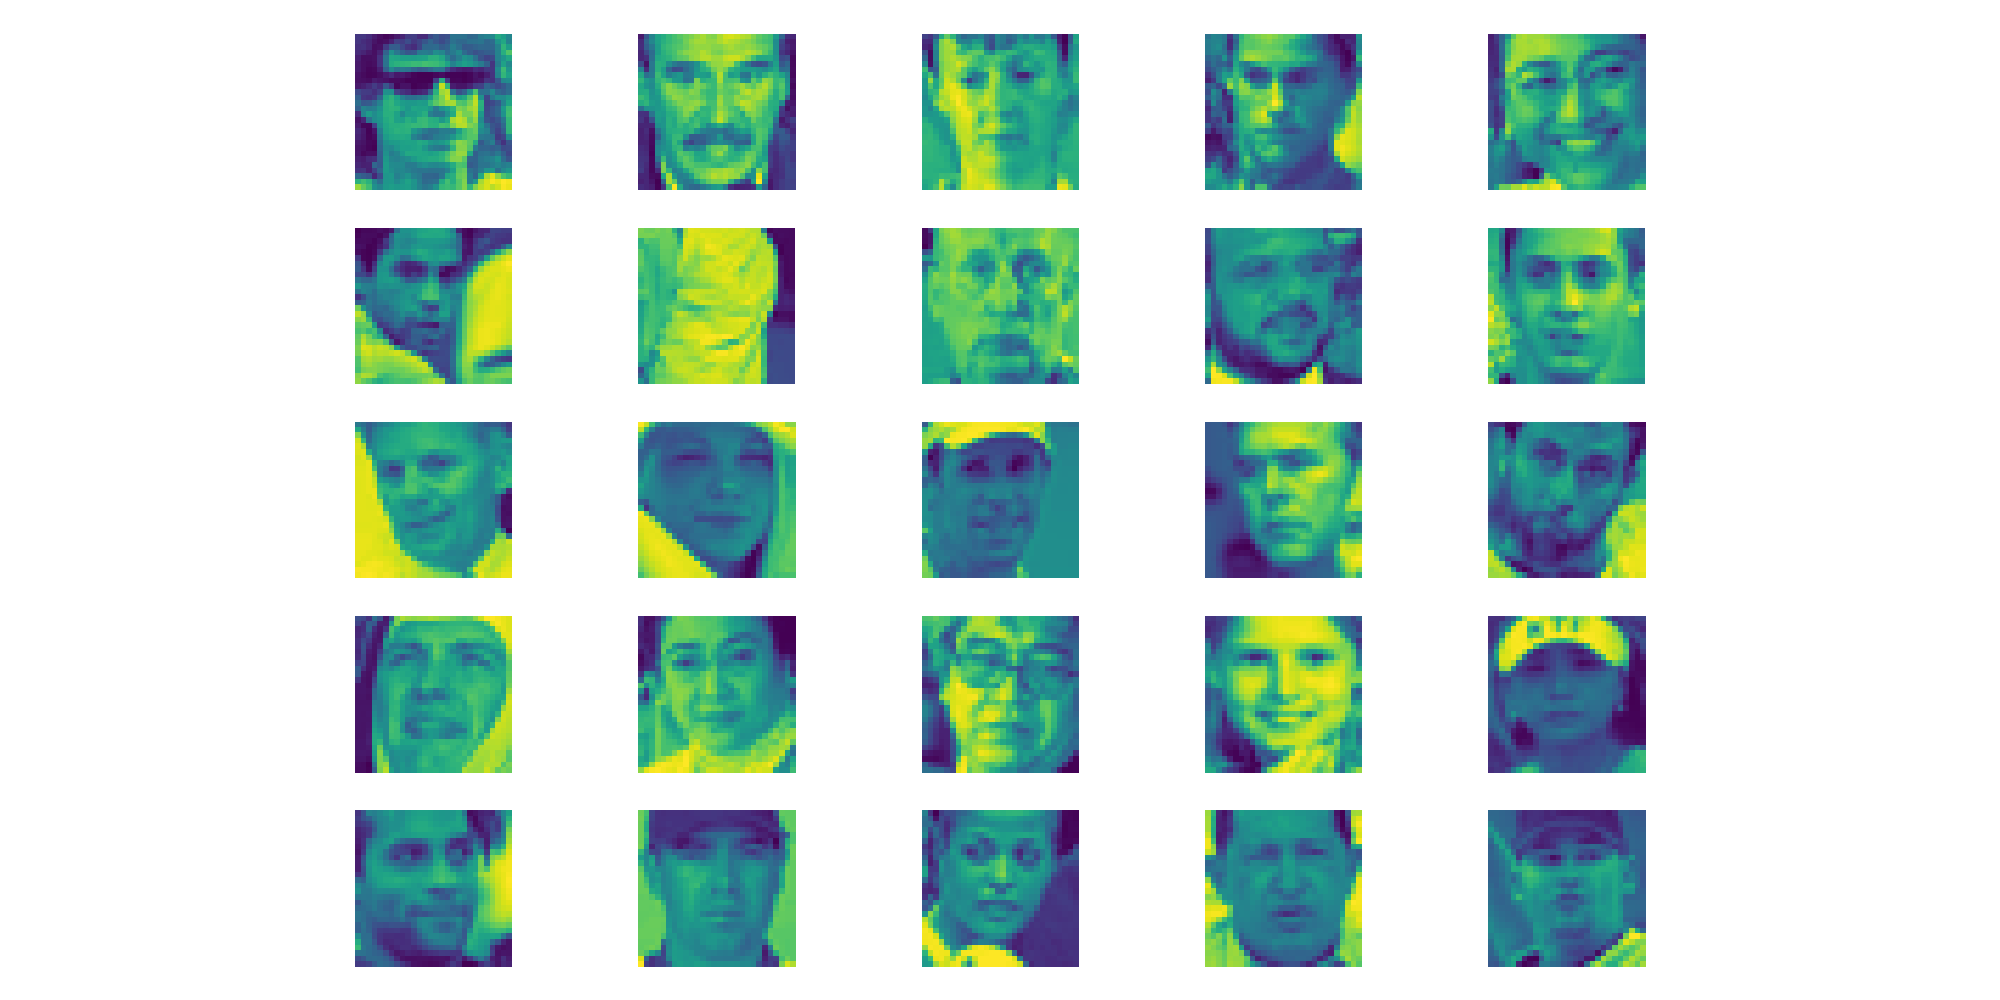

In [5]:
plt.figure(figsize=(10,5))
for i in range(1000,1025):
    plt.subplot(5,5,i+1-1000)
    plt.imshow(X_square[i,:,:])
    plt.xticks([]), plt.yticks([])
    plt.axis('off')
    plt.show()

<IPython.core.display.Javascript object>


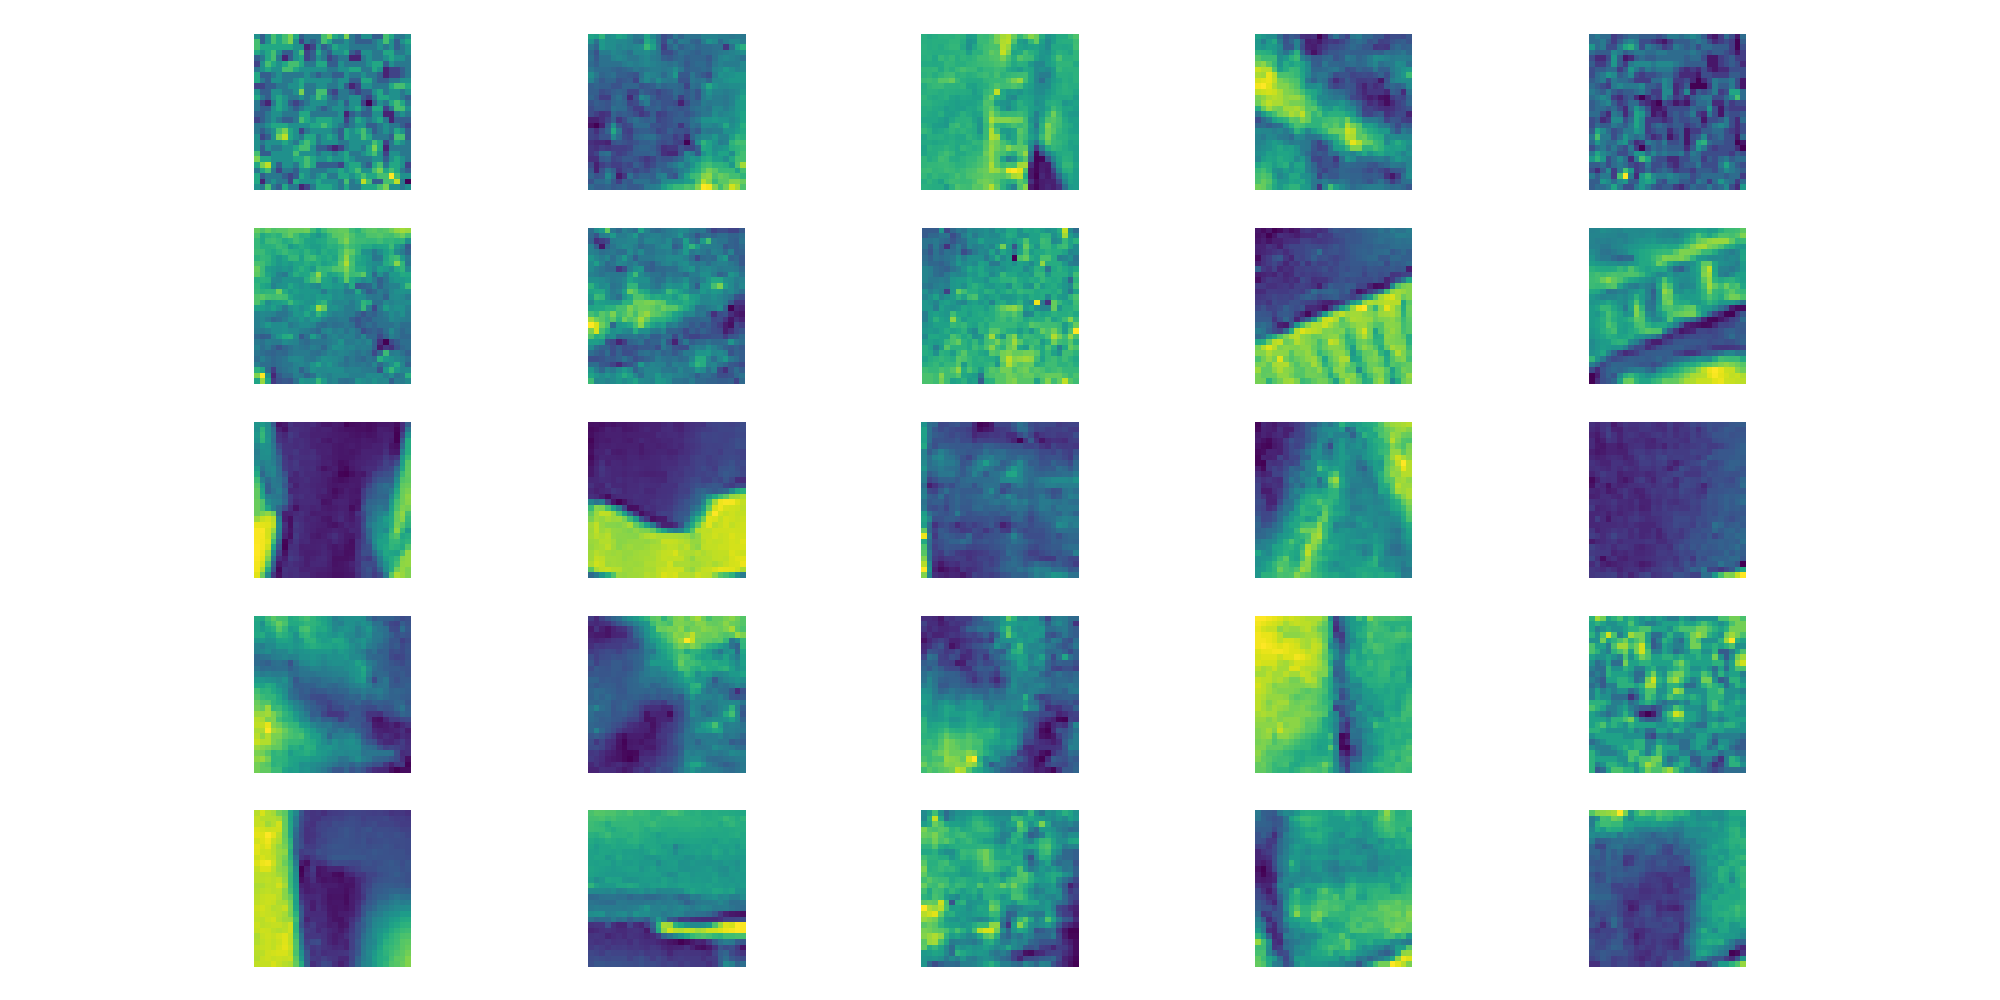

In [6]:
plt.figure(figsize=(10,5))
for i in range(9000,9025):
    plt.subplot(5,5,i+1-9000)
    plt.imshow(X_square[i,:,:])
    plt.xticks([]), plt.yticks([])
    plt.axis('off')
    plt.show()

### Pipeline

<figure>
<img src="../../mlrefined_images/convnet_images/pipeline.png" width="100%" height="auto"/>
</figure>

In [8]:
N0 = 3
N1 = 5

slider = []
for i in range(0, N0):
    for j in range(0, N1):
        slider.append([i,j])

In [9]:
slider

[[0, 0],
 [0, 1],
 [0, 2],
 [0, 3],
 [0, 4],
 [1, 0],
 [1, 1],
 [1, 2],
 [1, 3],
 [1, 4],
 [2, 0],
 [2, 1],
 [2, 2],
 [2, 3],
 [2, 4]]

In [10]:
slider[0]

[0, 0]

In [12]:
slider[14][1]

4